<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
# !pip3 install -U pandas numpy matplotlib seaborn scikit-learn Jinja2 phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re
import phik
# from ydata_profiling import ProfileReport

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?

`Your answer here`

Для повторяемости результата

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [3]:
try:
    df_train = pd.read_csv('data/df_train.csv', index_col='Unnamed: 0')
    df_test = pd.read_csv('data/df_test.csv', index_col='Unnamed: 0')
except:
    df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
    df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

    df_train.to_csv('data/df_train.csv')
    df_test.to_csv('data/df_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 765.5+ KB


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [4]:
df_train.isna().mean().to_frame('nan_values').style.background_gradient()

,nan_values
name,0.000000
year,0.000000
selling_price,0.000000
km_driven,0.000000
fuel,0.000000
seller_type,0.000000
transmission,0.000000
owner,0.000000
mileage,0.028861
engine,0.028861


Пропуски присутствуют в колонках: `['mileage', 'engine', 'max_power', 'torque', 'seats']`

In [5]:
df_train.duplicated().mean()

np.float64(0.14073439062723248)

В тренировочных данных примерно 14% дубликатов.

У меня в очередной раз были проблемы с запуском библиотеки ydata_profiling, поэтому я создал отчет в Colab, и приложил файл.

In [6]:
# profile = ProfileReport(df_train, title="Pandas Profiling Report")
# profile.to_file("df_train_report.html")

* Самая сильная отрицательная корреляция у переменной km_driven: -0.358
* Самая сильная положительная корреляция у переменной year: 0.714
* Остальные переменные также имеют корреляции 0.1 - 0.3 - 0.5, что позволяет предположить, что машинное обучение должно хорошо справиться с задачей предсказания цены автомобиля.
* Также есть сильная отрицательная корреляция между колонками km_driven и year
* Судя по WordCloud, в датасете данные с индийского авторынка. Самые популярные слова: maruti, mahindra
* Переменная year скошена вправо. Минимальное значение - 1983 год, 5% перцентиль - 2006 год. Максимальное значение - 2020 год.
* Целевая переменная price скошена влево. 5% перцентиль: 110000, 95% перцентиль: 1925000. Максимальное значение: 10000000. Нужно будет учитывать это при выборе функции потерь.
* Лучше всего представлены типы двигателей: Diesel, Petrol, типов CNG и LPG всего 1.2%
* Из колонок mileage, engine, max_power, torque можно вытащить численные данные

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [7]:
df_train.describe()

,year,selling_price,km_driven,seats
count,6999.000000,6.999000e+03,6.999000e+03,6797.000000
mean,2013.818403,6.395152e+05,6.958462e+04,5.419008
std,4.053095,8.089419e+05,5.772400e+04,0.965767
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.700000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [8]:
df_test.describe()

,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


In [9]:
diff = (df_train.describe() - df_test.describe()) / df_train.describe()
diff.loc[['mean', '50%'], :].style.format('{:.2%}')

,year,selling_price,km_driven,seats
mean,0.01%,3.38%,-2.60%,0.15%
50%,0.05%,3.33%,-2.50%,0.00%


* Между train и test датасетами разница в средних и медианах небольшая, максимум 3%.
* Сравнивая средние и медианы между собой можно понять скошенность признаков: year немного скошен вправо, selling_price и km_driven влево. seats имеет незначительную скошенность.

In [10]:
df_train.select_dtypes('object').describe()

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803,6796
unique,1924,4,3,2,5,386,120,316,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330,468


In [11]:
df_test.select_dtypes('object').describe()

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


По текстовым признакам пока сложно что-то сказать, нужно выполнять предобработку и формировать новые признаки

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [12]:
df_train.head(1)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


In [13]:
df_train.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [14]:
df_train[
    df_train.duplicated(
        keep='first',
        subset=['name', 'year', 'km_driven', 'fuel', 'seller_type',
                'transmission', 'owner', 'mileage', 'engine', 'max_power',
                'torque', 'seats'])]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0
258,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
268,Maruti Swift Dzire VXI,2014,400000,70000,Petrol,Individual,Manual,Second Owner,19.1 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,Chevrolet Spark 1.0 LS,2010,140000,60000,Petrol,Individual,Manual,Second Owner,18.0 kmpl,995 CC,62 bhp,90.3Nm@ 4200rpm,5.0
6984,Ford Freestyle Titanium Plus Diesel BSIV,2018,746000,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63 bhp,215Nm@ 1750-3000rpm,5.0
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


Всего 1159 объектов, у которых признаковое описание повторяется 2 или более раз.

Не совсем понял смысл строки, что делать, если при одинаковом признаковом описании цены не отличаются.
    
_Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю_

По логике нам в принципе нужно оставить только объекты с уникальными признаковыми описаниями. Просто если целевая переменная при этом различается, есть варианты. Сейчас просто удаляем лишние строки.

In [15]:
df_train = df_train.drop_duplicates(
    keep='first',
    subset=['name', 'year', 'km_driven', 'fuel', 'seller_type',
            'transmission', 'owner', 'mileage', 'engine', 'max_power',
            'torque', 'seats']).reset_index(drop=True)

In [16]:
df_train.shape

(5840, 13)

In [17]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [18]:
df_train[['mileage', 'engine', 'max_power', 'torque']].head()

,mileage,engine,max_power,torque
0,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
1,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm
2,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm
3,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)"
4,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm


По колонке torque можно также заметить, что присутствуют разные единицы измерения: Н\*м и кг\*м. Еще для RPM где-то указан диапазон оборотов, а где-то одно значение. И еще присутствуют разные разделители. Дальше следует куча преобразований...

In [19]:
def convert_columns(df):
    # Тут просто нужно выделить числа из строк
    pattern = r'(\d+\.?\d+?)'
    df['mileage'] = df['mileage'].str.extract(pattern).astype('float')
    df['engine'] = df['engine'].str.extract(pattern).astype('float')
    df['max_power'] = df['max_power'].str.extract(pattern).astype('float')

    # Разделяем torque на 2 колонки
    df[['max_torque', 'torque_rpm']] = df['torque'].str.split('@|at', expand=True, n=1)
    df = df.drop('torque', axis=1)

    # Определяем единицы измерения момента
    df['torque_measure'] = np.where(
        df['max_torque'].str.lower().str.extract('(kgm|nm)', expand=False).isna(),
        df['torque_rpm'].str.lower().str.extract('(kgm|nm)', expand=False),
        df['max_torque'].str.lower().str.extract('(kgm|nm)', expand=False)
    )

    # Определяем максимальный момент и переводим в нужные единицы если нужно
    pattern = r'(\d+\.?\d+?)'
    df['max_torque'] = df['max_torque'].str.extract(pattern).astype('float')
    df['max_torque'] = np.where(
        df['torque_measure'] == 'kgm',
        df['max_torque']*9.8,
        df['max_torque']
    )
    df = df.drop('torque_measure', axis=1)

    # Выделяем диапазон оборотов максимального момента
    pattern = r'(\d+\,?\d+)-?(\d+\,?\d+)?'
    df[['min_torque_rpm', 'max_torque_rpm']] = df['torque_rpm'].str.extract(pattern)
    df = df.drop('torque_rpm', axis=1)

    df['min_torque_rpm'] = df['min_torque_rpm'].str.replace(',', '').astype('float')
    df['max_torque_rpm'] = df['max_torque_rpm'].str.replace(',', '').astype('float')
    df['max_torque_rpm'] = np.where(
        df['max_torque_rpm'].isna(),
        df['min_torque_rpm'],
        df['max_torque_rpm']
    )

    return df

In [20]:
df_train = convert_columns(df_train)

In [21]:
df_test = convert_columns(df_test)

In [22]:
df_train.shape, df_test.shape

((5840, 15), (1000, 15))

In [23]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248.0,74.0,5.0,190.00,2000.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.1,1498.0,103.5,5.0,250.00,1500.0,2500.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396.0,90.0,5.0,219.52,1750.0,2750.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298.0,88.2,5.0,112.70,4500.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.1,1197.0,81.8,5.0,113.70,4000.0,4000.0


### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






Медиану приоритетнее как правило в тех случаях, когда есть сильно отклоняющие от среднего значения, которые могут смещать среднее в свою сторону.

По поводу заполнения пропусков. Нужно заполнять медианой из тренировочных данных, т.к. нам нельзя подглядывать в тестовые данные, иначе оценка модели может быть слишком оптимистичной. Тестове данные используются для финальной оценки модели, и мы не можем использовать данные, которых у нас не было на этапе обучения. Можно отметить, что если попытаться заполнить тестовые данные своей медианой - это не то же самое, что и peaking problem, или data leakage (в случае, если тестовая выборка испльзуется именно для финальной оценки, а не при настройке гиперпараметров или EDA). Мы предобрабатываем тестовые данные, и теоретически заполнение медианой по тестовым данным можно посчитать как частью предобработки. Но  насколько я понял, так не делают, т.к. процесс становится непредсказуемым. Ну и мы обычно считаем, что тренировочные данные - это лучшая репрезентация генеральной совокупности, поэтому медиана из тестовых данных может теоретически сделать даже хуже.

In [24]:
df_train.isna().mean()

name              0.000000
year              0.000000
selling_price     0.000000
km_driven         0.000000
fuel              0.000000
seller_type       0.000000
transmission      0.000000
owner             0.000000
mileage           0.031849
engine            0.031849
max_power         0.032021
seats             0.031849
max_torque        0.032192
min_torque_rpm    0.033904
max_torque_rpm    0.033904
dtype: float64

In [25]:
def fill_medians(df_train, df_test):
    medians = df_train.select_dtypes('number').loc[:, df_train.isna().mean() > 0].median().to_dict()

    for col, median in medians.items():
        df_train[col] = df_train[col].fillna(median)
        df_test[col] = df_test[col].fillna(median)

    return df_train, df_test

In [26]:
df_train, df_test = fill_medians(df_train, df_test)

In [27]:
df_train.shape, df_test.shape

((5840, 15), (1000, 15))

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [28]:
df_train['engine'] = df_train['engine'].astype('int')
df_train['seats'] = df_train['seats'].astype('int')

df_test['engine'] = df_test['engine'].astype('int')
df_test['seats'] = df_test['seats'].astype('int')

`Your answer here`

Переменная seats - количество сидений - может рассматриваться и как количественная переменная, и как категориальная, т.к. в каком-то смысле здесь явное "количество", т.е. 5 это больше, чем 4. С другой стороны, это количество может работать хуже, чем если взять каджую цифру как отдельную категорию.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [29]:
df_train.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.409675,1429.448973,87.937534,5.426712,175.362764,2659.387500,3046.251370
std,4.095622,5.354320e+05,6.007114e+04,3.984538,485.662834,31.577799,0.982344,107.102037,1116.192693,910.125395
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,2.000000,47.040000,175.000000,1400.000000
25%,2011.000000,2.500000e+05,3.900000e+04,16.900000,1197.000000,68.000000,5.000000,111.800000,1750.000000,2400.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.350000,1248.000000,81.800000,5.000000,160.000000,2000.000000,3000.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.300000,1498.000000,99.000000,5.000000,200.000000,3750.000000,4000.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000,1862.000000,21800.000000,21800.000000


`Your answer here`

Ну во-первых, из всех колонок, где мы заполняли пропуски, у нас изначально была только 'seats', а остальные были получены из текстовых данных. Распределение да, будет сдвинуто теперь с сторону медианы + добавится неравномерность (медиана будет выделяться). Если была скошенность, то среднее сдвинется в сторону медианы.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [30]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248,74.0,5,190.00,2000.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.1,1498,103.5,5,250.00,1500.0,2500.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396,90.0,5,219.52,1750.0,2750.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298,88.2,5,112.70,4500.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.1,1197,81.8,5,113.70,4000.0,4000.0


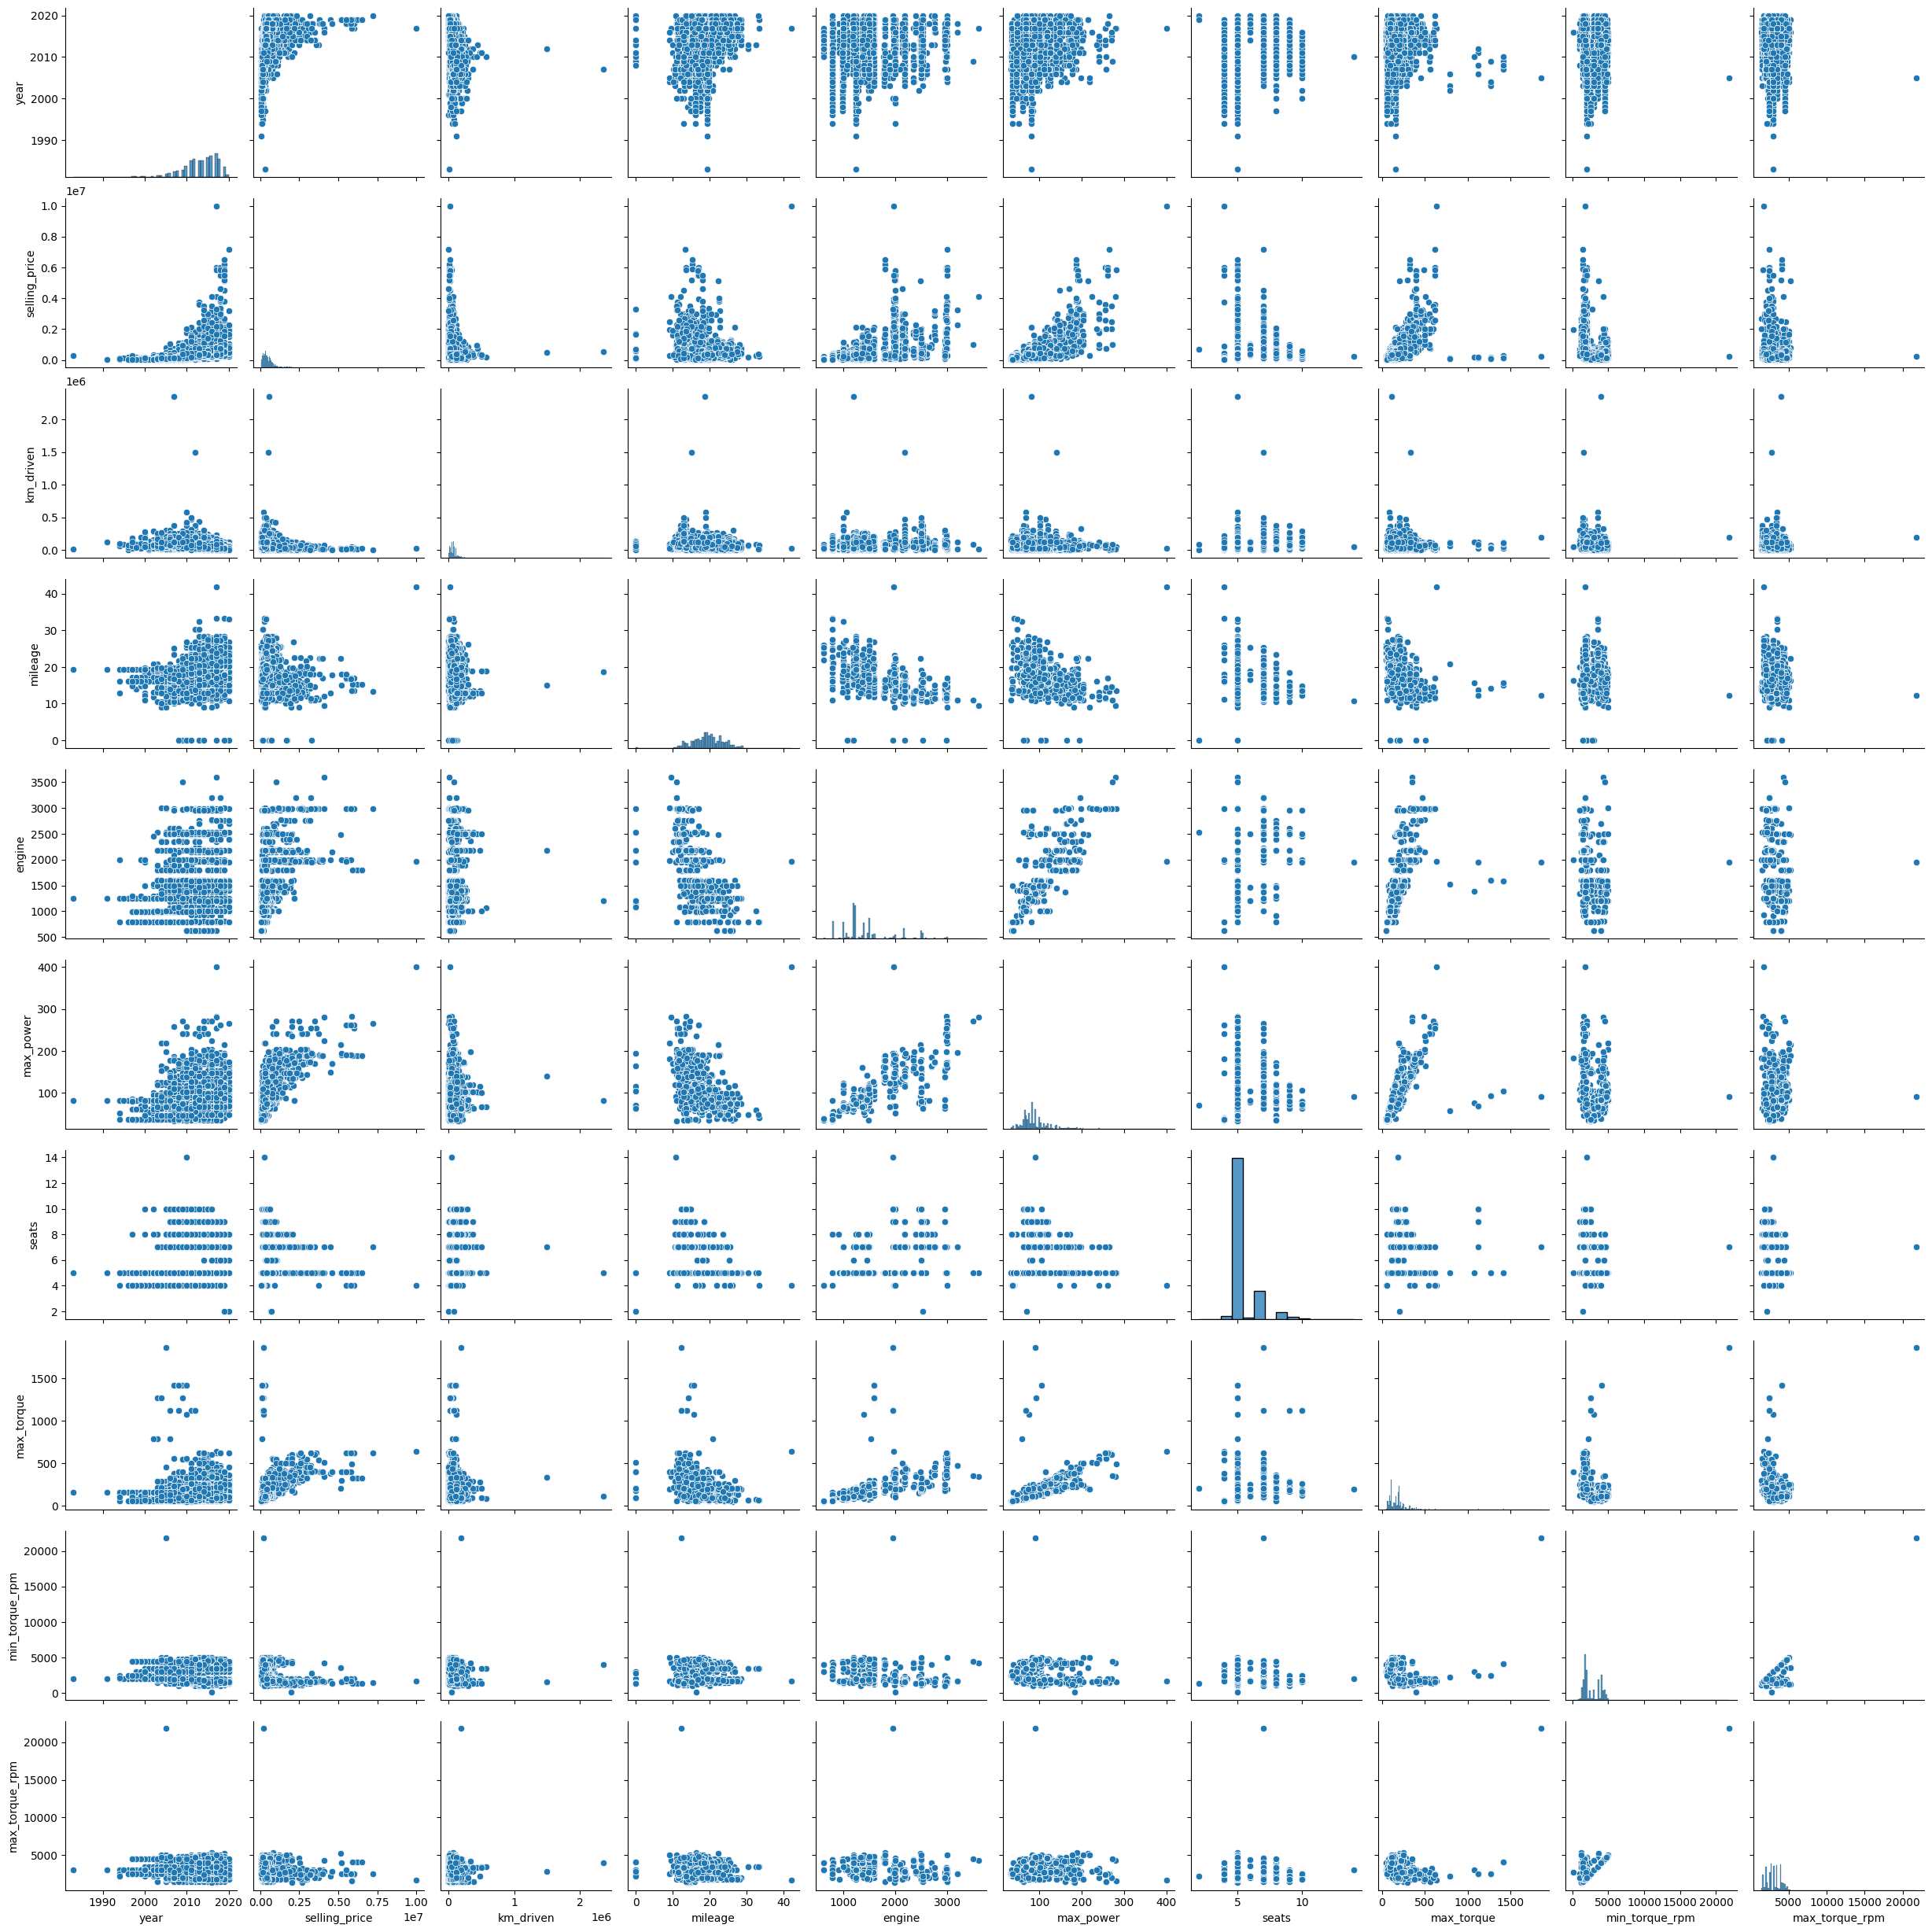

In [31]:
sns.pairplot(df_train)

plt.show()

1. Да, по диаграммам видно, что связь переменных с целевой переменной прослеживается. Особенно можно выделить сильную корреляцию с целевой переменной фичей 'max_torque' и 'max_power'
2. Также можно проследить корреляции между остальными признаками. Например те же 'max_torque', 'max_power' и 'engine' (displacement) сильно коррелируют между собой.

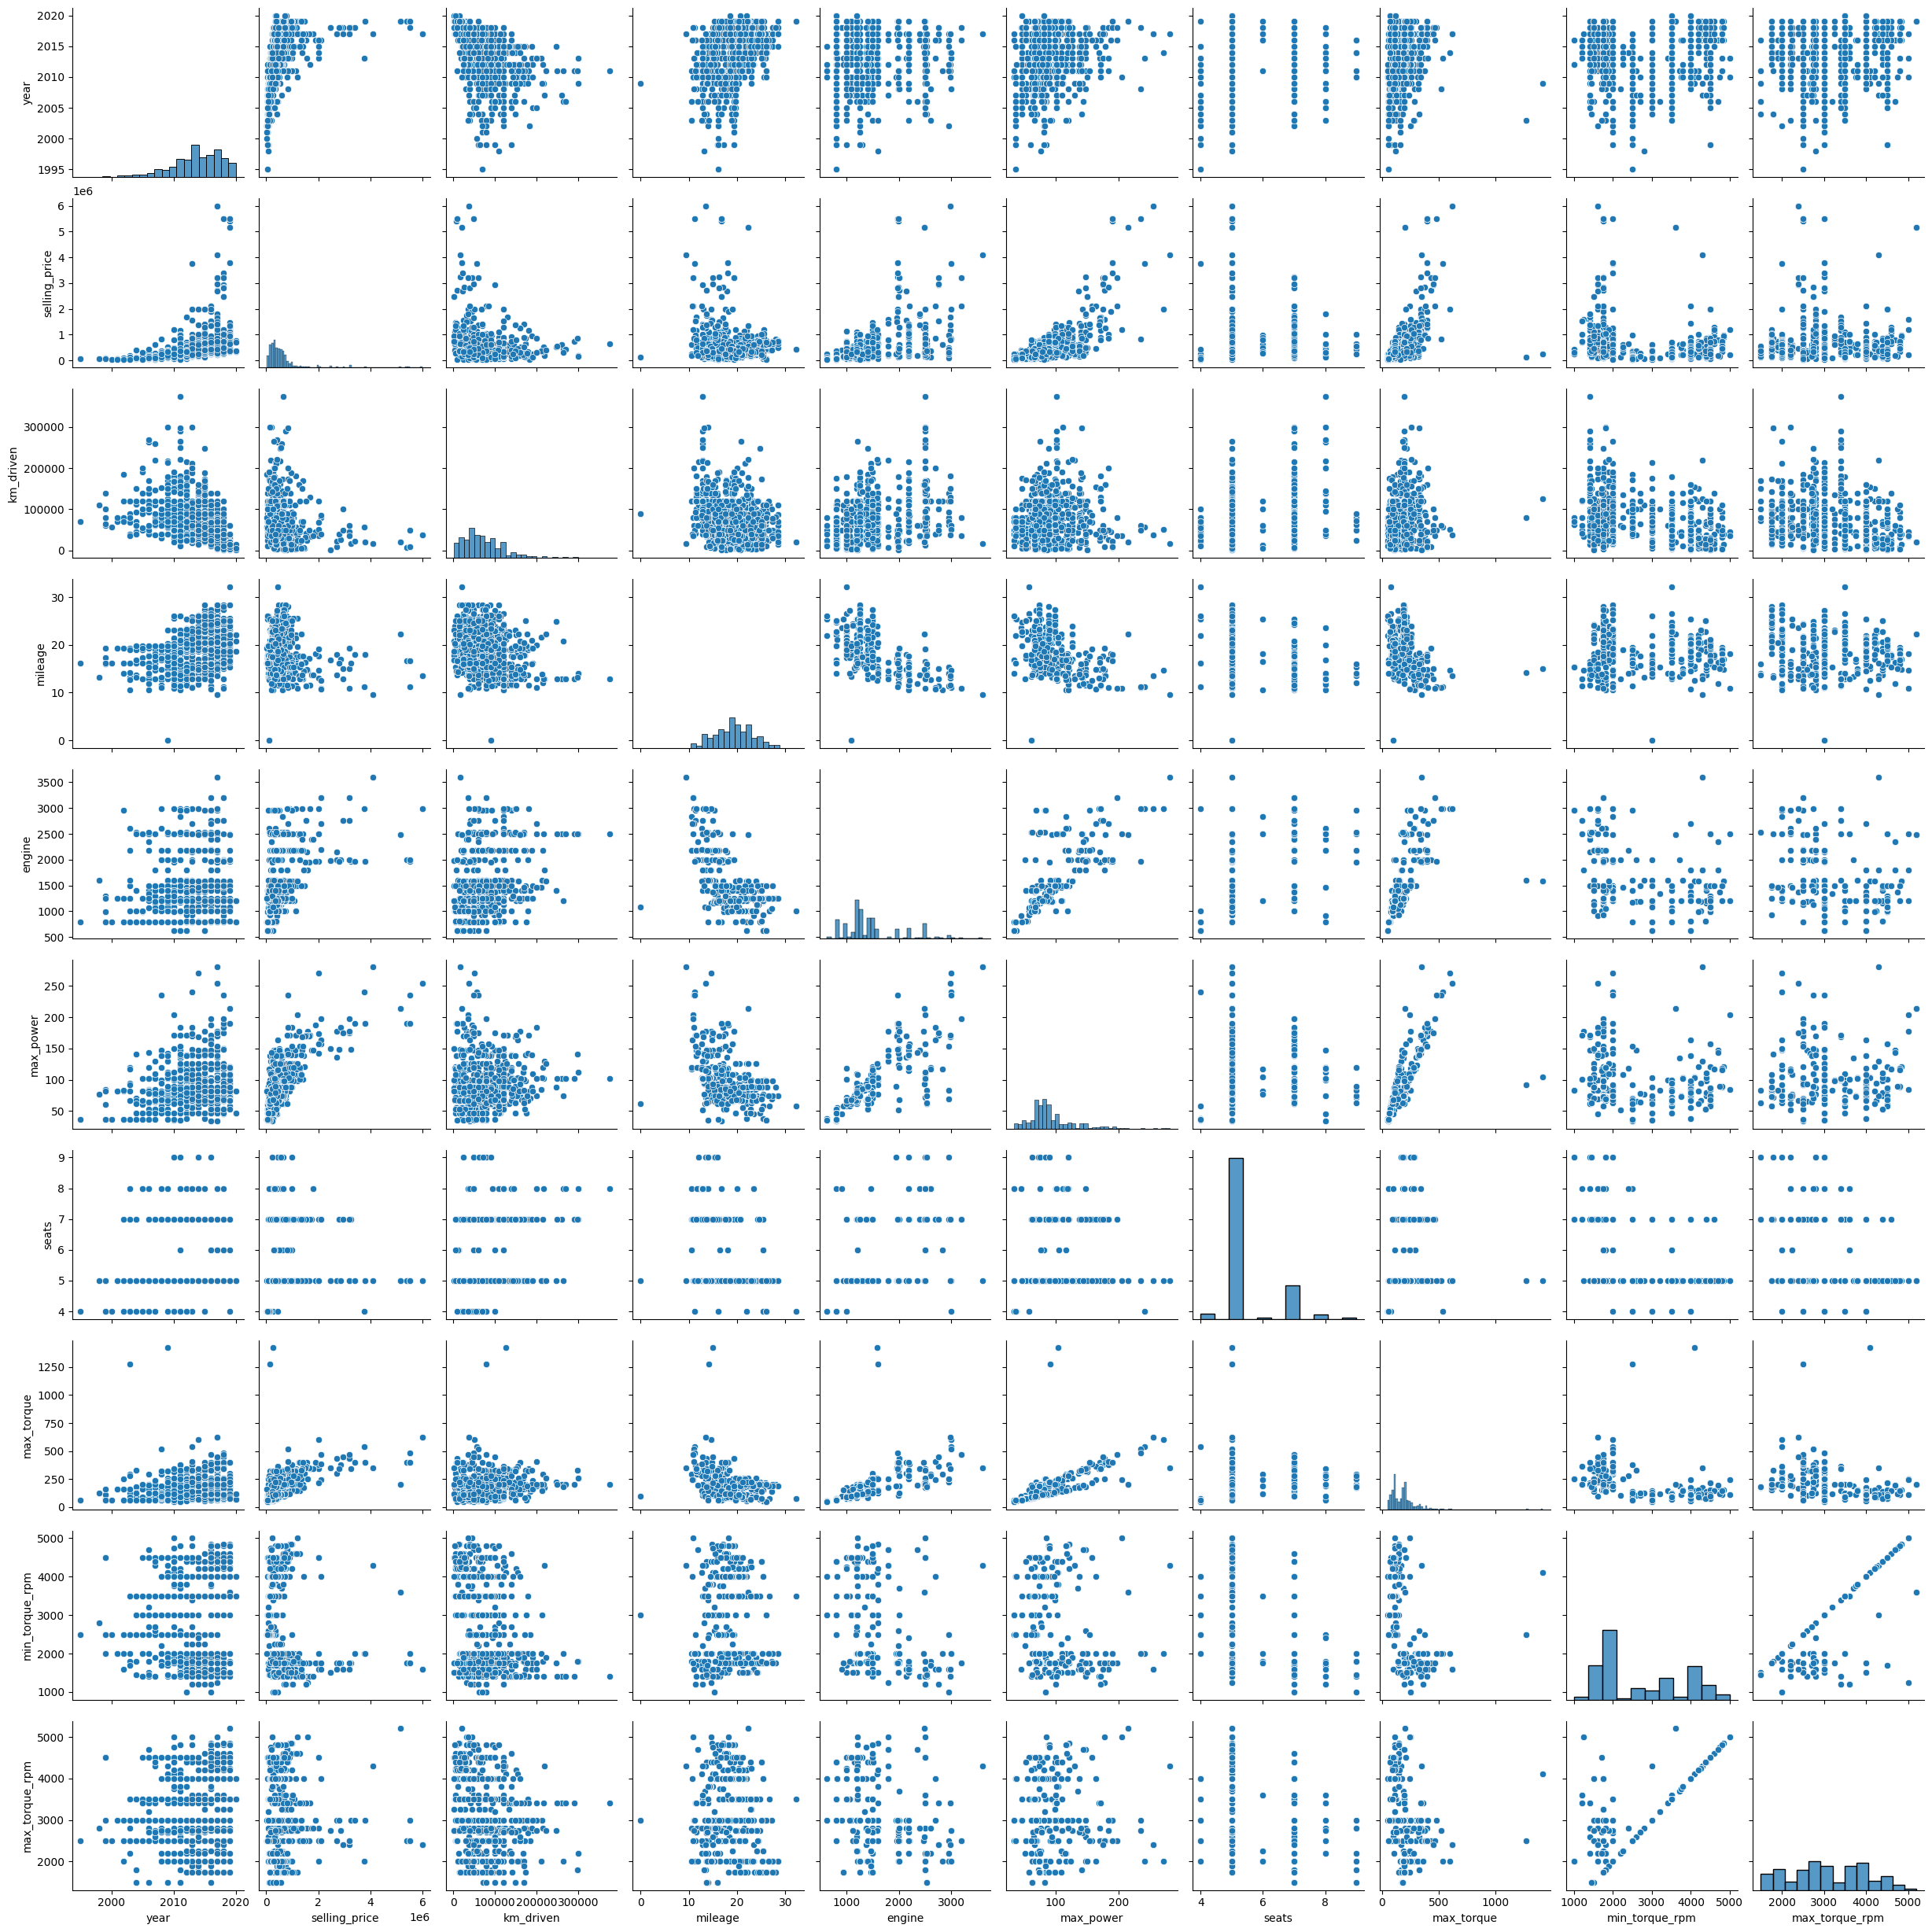

In [32]:
sns.pairplot(df_test)

plt.show()

Распределения похожи. Некоторые диаграммы отображены в другом масштабе, т.к. в тренировочных данных присутвуют сильно выбивающиеся значения, которых нет (меньше) в тестовых данных. Например, единичные выбросы в train в 'min_torque_rpm' и 'max_torque_rpm' сдвигают графики с основной частью к краю, чего не наблюдается в тестовых данных

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

Мне больше нравится такой хитмап

In [33]:
df_train.select_dtypes('number').corr().style.background_gradient(cmap='seismic', vmin=-1, vmax=1)

,year,selling_price,km_driven,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm
year,1.000000,0.427279,-0.368966,0.339938,0.002819,0.157073,0.041178,0.053144,0.008515,0.047350
selling_price,0.427279,1.000000,-0.164828,-0.106004,0.447672,0.693731,0.149953,0.466555,-0.241128,-0.088502
km_driven,-0.368966,-0.164828,1.000000,-0.182069,0.229766,0.024589,0.192328,0.113020,-0.237098,-0.203421
mileage,0.339938,-0.106004,-0.182069,1.000000,-0.574323,-0.375003,-0.452524,-0.238592,-0.009067,-0.180309
engine,0.002819,0.447672,0.229766,-0.574323,1.000000,0.682044,0.652172,0.600046,-0.474632,-0.244349
max_power,0.157073,0.693731,0.024589,-0.375003,0.682044,1.000000,0.244099,0.661048,-0.258488,-0.023593
seats,0.041178,0.149953,0.192328,-0.452524,0.652172,0.244099,1.000000,0.316297,-0.352924,-0.206689
max_torque,0.053144,0.466555,0.113020,-0.238592,0.600046,0.661048,0.316297,1.000000,-0.426494,-0.268540
min_torque_rpm,0.008515,-0.241128,-0.237098,-0.009067,-0.474632,-0.258488,-0.352924,-0.426494,1.000000,0.840091
max_torque_rpm,0.047350,-0.088502,-0.203421,-0.180309,-0.244349,-0.023593,-0.206689,-0.268540,0.840091,1.000000


<Axes: >

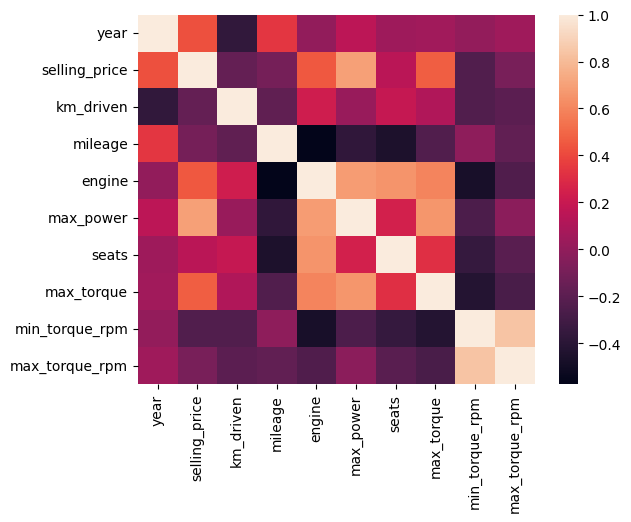

In [34]:
sns.heatmap(df_train.select_dtypes('number').corr())

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

`Your answer here`

* Наименее скоррелированные 2 признака: 'engine' и 'year'. Также очень низкая корреляция между: 'max_power' - 'km_driven', 'min_torque_rpm' - 'mileage', 'max_torque_rpm' - 'max_power'
* Наиболее сильная положительная корреляция у набора признаков: 'max_power' - 'max_torque' - 'engine' - 'price'
* Да, между 'year' и 'km_driven' коэффициент корреляции равен -0.37, что соответствует средне-слабой отрицательной взаимосвязи.

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


$$
\text{Spearman Correlation Coefficient}\\
$$
$$
\rho = 1 - \frac{6 \sum_{i=1}^n (R(x_i) - R(y_i))^2}{n(n^2 - 1)}
$$


In [35]:
def spearman_corr(x, y):
    n = len(x)

    rank_x = np.argsort(np.argsort(x))
    rank_y = np.argsort(np.argsort(y))
    
    rho = 1 - (6 * np.sum((rank_x - rank_y) ** 2)) / (n * (n**2 - 1))
    return rho

In [36]:
spearman_corr(df_train['max_power'], df_train['max_torque'])

np.float64(0.7761946892392445)

In [37]:
df_train[['max_power', 'max_torque']].corr(method='spearman')

,max_power,max_torque
max_power,1.000000,0.776964
max_torque,0.776964,1.000000


In [38]:
df_train.phik_matrix().style.background_gradient()

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'max_torque', 'min_torque_rpm', 'max_torque_rpm']


c:\Users\user\MyGitRepos\masters\ML\.venv\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm
name,1.000000,0.948995,0.994871,0.000000,1.000000,0.799127,1.000000,0.830098,0.999690,1.000000,0.999985,0.999985,0.999978,0.999942,0.999942
year,0.948995,1.000000,0.219841,0.081574,0.205834,0.232412,0.153714,0.418636,0.277575,0.213156,0.164596,0.288178,0.185089,0.158178,0.270911
selling_price,0.994871,0.219841,1.000000,0.000000,0.157885,0.334505,0.463058,0.557641,0.649797,0.503682,0.764433,0.196447,0.687135,0.181498,0.203614
km_driven,0.000000,0.081574,0.000000,1.000000,0.046285,0.000000,0.012824,0.087887,0.081401,0.210747,0.000000,0.096223,0.000000,0.021597,0.049696
fuel,1.000000,0.205834,0.157885,0.046285,1.000000,0.050771,0.053721,0.030943,0.580164,0.644421,0.436620,0.450714,0.349334,0.851704,0.563901
seller_type,0.799127,0.232412,0.334505,0.000000,0.050771,1.000000,0.127968,0.176612,0.068635,0.160346,0.234714,0.032173,0.147800,0.078712,0.149495
transmission,1.000000,0.153714,0.463058,0.012824,0.053721,0.127968,1.000000,0.096990,0.334178,0.520161,0.683199,0.045734,0.362304,0.051085,0.030943
owner,0.830098,0.418636,0.557641,0.087887,0.030943,0.176612,0.096990,1.000000,0.150015,0.186011,0.147316,0.046741,0.059774,0.000000,0.112724
mileage,0.999690,0.277575,0.649797,0.081401,0.580164,0.068635,0.334178,0.150015,1.000000,0.587762,0.835534,0.679684,0.377465,0.408448,0.312494
engine,1.000000,0.213156,0.503682,0.210747,0.644421,0.160346,0.520161,0.186011,0.587762,1.000000,0.729970,0.603400,0.611920,0.640781,0.640995


`Your answer here`

* При построении матрицы корреляций phik мы сразу видим warning, что поле name имеет много уникальных значений. Поэтому и коффицииенты $\phi$ для поля name почти все около 1.
* Для поля selling_price теперь можно посмотреть корреляции с категориальными переменными. Так, высокая корреляция у поля owner: 0.56.
* При этом например для поля km_driven корреляции ниже, чем были в корреляциями Пирсона.
* Еще из интересного - поле fuel очень хорошо объясняет min_torque_rpm - минимальные обороты максимального крутящего момента (что логично с точки зрения конструкции
* Для числовых переменных картина похожая с корреляциями Пирсона (учитывая только что $\phi$ имеет диапазон от 0 до 1)

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

Можем попробовать вытащить марки и модели из поля 'name'

In [39]:
# Я пошел по простому пути, и просто оставил первые 2 колонки
df_train[['brand', 'model']] = df_train['name'].str.split(' ', expand=True)[[0, 1]]
df_train = df_train.drop('name', axis=1)

df_test[['brand', 'model']] = df_test['name'].str.split(' ', expand=True)[[0, 1]]
df_test = df_test.drop('name', axis=1)

In [40]:
print(f'Количество уникальных марок в датасете: {df_train['brand'].nunique()}')
df_train['brand'].value_counts().head(10)

Количество уникальных марок в датасете: 30


brand
Maruti        1804
Hyundai       1058
Mahindra       611
Tata           534
Toyota         309
Ford           308
Honda          308
Chevrolet      188
Renault        171
Volkswagen     153
Name: count, dtype: int64

In [41]:
print(f'Количество уникальных моделей в датасете: {df_train['model'].nunique()}')
df_train['model'].value_counts().head(10)

Количество уникальных моделей в датасете: 202


model
Swift     558
Alto      316
i20       247
Wagon     205
Innova    160
Bolero    156
Verna     149
City      141
Figo      135
Grand     130
Name: count, dtype: int64

In [42]:
df_train[['brand', 'model', 'selling_price']].phik_matrix()

interval columns not set, guessing: ['selling_price']


,brand,model,selling_price
brand,1.000000,0.999851,0.716514
model,0.999851,1.000000,0.972390
selling_price,0.716514,0.972390,1.000000


Кажется, новые переменные 'brand' и 'model' очень хорошо объясняют целевую переменную

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [43]:
df_train_numbers = df_train.select_dtypes('number')
df_test_numbers = df_test.select_dtypes('number')

In [44]:
df_train_numbers.head(2)

,year,selling_price,km_driven,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm
0,2014,450000,145500,23.4,1248,74.0,5,190.0,2000.0,2000.0
1,2014,370000,120000,21.1,1498,103.5,5,250.0,1500.0,2500.0


In [45]:
y_train = df_train_numbers['selling_price']
X_train = df_train_numbers.drop('selling_price', axis=1)
X_train.shape, y_train.shape

((5840, 9), (5840,))

Следующая проверка не учитывает новые признаки ['max_torque', 'min_torque_rpm', 'max_torque_rpm'], поэтому я расширил количество колонок до 9

In [46]:
# assert X_train.shape == (5840, 6)
assert X_train.shape == (5840, 9)

In [47]:
y_test = df_test_numbers['selling_price']
X_test = df_test_numbers.drop('selling_price', axis=1)
X_test.shape, y_test.shape

((1000, 9), (1000,))

In [48]:
# assert X_test.shape == (1000, 6)
assert X_test.shape == (1000, 9)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model = LinearRegression()
model.fit(X_train, y_train)
pred_train_numbers = model.predict(X_train)
pred_test_numbers = model.predict(X_test)

print('R2 train: {}\nMSE train: {}\nR2 test: {}\nMSE test: {}'.format(
    r2_score(y_train, pred_train_numbers),
    MSE(y_train, pred_train_numbers),
    r2_score(y_test, pred_test_numbers),
    MSE(y_test, pred_test_numbers)
))

R2 train: 0.6021254536490265
MSE train: 114046098840.94096
R2 test: 0.6000488970051926
MSE test: 229903314860.50784


В целом, качество среднее. R2 = 0.6, что говорит о том, что модель может объяснить только 60% дисперсии в данных. Хороший бейзлайн.

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$
$$
y_i \text{ - истинные значени целевой переменной}\\
\hat{y}_i \text{ - предсазанные значения}\\
\bar{y} \text{ - среднее значение целевой переменной}
$$

Другими словами, R2 показывает, насколько предсказания модели лучше предсказания константой - средним (или хуже, если $R^2 < 0$)

In [50]:
def r2_manual(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    r2 = 1 - ss_res / ss_tot

    return r2

In [51]:
r2_manual(y_train, pred_train_numbers)

np.float64(0.6021254536490265)

`Your answer here`

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

$$
\bar{R}^2 = 1 - \frac{\frac{SS_{res}}{df_{res}}}{\frac{SS_{tot}}{df_{tot}}} = 1 - (1 - R^2)(\frac{n - 1}{n - p - 1})
$$

Adjuested $R^2$ учитывает не только часть дисперсии, объясненную моделью, но и 'model complexity' - отношение количества признаков к количеству наблюдений. Таким образом, Adjuested $R^2$ будет увеличиваться, если добавление новых признаков приносит больше информации, чем хаоса / запутанности. И Adjuested $R^2$ будет уменьшаться, если добавление новых признаков будет приносить больше хаоса в данные, чем повышать % объясненности дисперсии.

Поэтому Adjuested $R^2$ применяется тогда, когда мы хотим получить оптимальную 'model complexity'. Минимизируя Adjuested $R^2$ мы получаем оптимальную (или одну из оптимальных) сложность модели согласно понятию Bias Variance Tradeoff, где высоки Bias соответствует слишком простой модели (простыми словами - предвзято предсказывает, т.к. не знает достаточно информации о данных, признаков недостаточно, объектов - много), а высокий Variance соответствует переусложненной модели (простыми словами - большое количество признаков и недостаточное количество наблюдений по отношению к признакам привело к тому, что модель выучила шум.)

In [52]:
def r2_adj(y_true, y_pred, X):
    n = X.shape[0]
    p = X.shape[1]

    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    
    r2 = 1 - ss_res / ss_tot
    r2_adj = 1 - (1 - r2)*((n - 1) / (n - p - 1))

    return r2_adj

In [53]:
r2_adj(y_train, pred_train_numbers, X_train)

np.float64(0.601511239083476)

`Your answer here`

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

number_cols = X_train.columns

X_train = scaler.fit_transform(X_train, )
X_test = scaler.transform(X_test)

In [55]:
model = LinearRegression()
model.fit(X_train, y_train)
pred_train_numbers = model.predict(X_train)
pred_test_numbers = model.predict(X_test)

print('R2 train: {}\nMSE train: {}\nR2 test: {}\nMSE test: {}'.format(
    r2_score(y_train, pred_train_numbers),
    MSE(y_train, pred_train_numbers),
    r2_score(y_test, pred_test_numbers),
    MSE(y_test, pred_test_numbers)
))

R2 train: 0.6021254536490246
MSE train: 114046098840.94153
R2 test: 0.6000488970051912
MSE test: 229903314860.50867


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [56]:
coef_index = np.argsort(np.abs(model.coef_))[::-1]

importances = {}
for col, coef in zip(number_cols[coef_index], model.coef_[coef_index]):
    importances[col] = round(coef)

importances

{'max_power': 327710,
 'year': 164918,
 'km_driven': -49569,
 'max_torque_rpm': -37736,
 'seats': -30935,
 'min_torque_rpm': -26218,
 'engine': 16704,
 'mileage': -8888,
 'max_torque': 6318}

'max_power' - самый сильный признак

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [57]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train, y_train)
pred_train_numbers = model.predict(X_train)
pred_test_numbers = model.predict(X_test)

print('R2 train: {}\nMSE train: {}\nR2 test: {}\nMSE test: {}'.format(
    r2_score(y_train, pred_train_numbers),
    MSE(y_train, pred_train_numbers),
    r2_score(y_test, pred_test_numbers),
    MSE(y_test, pred_test_numbers)
))

R2 train: 0.6021254536016456
MSE train: 114046098854.52213
R2 test: 0.6000476594589186
MSE test: 229904026237.4451


In [58]:
model.coef_

array([164915.83817641, -49568.13092097,  -8883.88532919,  16702.75545514,
       327711.45066769, -30931.31368066,   6317.17630083, -26217.97833669,
       -37734.02601458])

С стандартными параметрами зануления признаков не произошло. Качество модели осталось примерно на том же уровне.

In [59]:
model = Lasso(alpha=10000)
model.fit(X_train, y_train)
pred_train_numbers = model.predict(X_train)
pred_test_numbers = model.predict(X_test)

print('R2 train: {}\nMSE train: {}\nR2 test: {}\nMSE test: {}'.format(
    r2_score(y_train, pred_train_numbers),
    MSE(y_train, pred_train_numbers),
    r2_score(y_test, pred_test_numbers),
    MSE(y_test, pred_test_numbers)
))

model.coef_

R2 train: 0.5995578433702313
MSE train: 114782074384.80544
R2 test: 0.5866779472044499
MSE test: 237589318621.98297


array([153352.10704623, -40065.21122338,      0.        ,      0.        ,
       331932.92315299,  -3092.00033173,   1005.7234247 , -22635.60732684,
       -26316.01947903])

Занулить параметры модели удалось только при `alpha=10000`, при этом качество модели ухудшилось. Видимо, признаки все важные. Но метрику проверяли мы на train, что не совсем корректно

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [61]:
X_train = df_train_numbers.drop('selling_price', axis=1)
X_test = df_test_numbers.drop('selling_price', axis=1)
number_cols = X_train.columns

In [62]:
%%time

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, number_cols),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000, 100000, 10**9]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='r2',
    verbose=4,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

def get_grid_results(grid_search, X_train, X_test, y_train, y_test):
    best_pipe = grid_search.best_estimator_

    pred_train_numbers = best_pipe.predict(X_train)
    pred_test_numbers = best_pipe.predict(X_test)

    print('R2 train: {}\nMSE train: {}\nR2 test: {}\nMSE test: {}'.format(
        r2_score(y_train, pred_train_numbers),
        MSE(y_train, pred_train_numbers),
        r2_score(y_test, pred_test_numbers),
        MSE(y_test, pred_test_numbers)
    ))

    print('*'*50)
    print(grid_search.best_params_)
    print("Best R2 Score:", grid_search.best_score_)

    print('*'*50)
    print("Regression coefficients:")
    for col, coef in zip(number_cols, best_pipe.named_steps['model'].coef_):
        print(col, round(coef))
    print('*'*50)

get_grid_results(grid_search, X_train, X_test, y_train, y_test)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
R2 train: 0.5995578433702313
MSE train: 114782074384.80544
R2 test: 0.5866779472044499
MSE test: 237589318621.98297
**************************************************
{'model__alpha': 10000}
Best R2 Score: 0.5795559467550502
**************************************************
Regression coefficients:
year 153352
km_driven -40065
mileage 0
engine 0
max_power 331933
seats -3092
max_torque 1006
min_torque_rpm -22636
max_torque_rpm -26316
**************************************************
CPU times: total: 15.6 ms
Wall time: 301 ms


Всего 90 фолдов обучались 363мс.

В Lasso Regression мы настраивали единственный параметр - 'alpha' - коэффициент регуляризации. Это коэффициент при регуляризационном члене.

При обучении с GridSearch лучшим коэффициентом оказался `alpha = 10000`, при этом занулились коэффициенты для колонок 'mileage' и 'engine'

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [63]:
from sklearn.linear_model import ElasticNet

In [64]:
%%time

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, number_cols),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000, 100000, 10**9],
    'model__l1_ratio': np.arange(0, 1.01, 0.1)
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='r2',
    verbose=4,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

get_grid_results(grid_search, X_train, X_test, y_train, y_test)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
R2 train: 0.5995578433702313
MSE train: 114782074384.80544
R2 test: 0.5866779472044499
MSE test: 237589318621.98297
**************************************************
{'model__alpha': 10000, 'model__l1_ratio': np.float64(1.0)}
Best R2 Score: 0.5795559467550502
**************************************************
Regression coefficients:
year 153352
km_driven -40065
mileage 0
engine 0
max_power 331933
seats -3092
max_torque 1006
min_torque_rpm -22636
max_torque_rpm -26316
**************************************************
CPU times: total: 484 ms
Wall time: 1.47 s


В Elastic Net обучалось 990 фолдов, всего времени потрачено 1.49с.

К коэффициенту регуляризации добавился параметр 'l1_ratio' - пропорция L1 регуляризации в отношении L1 - L2.

Победила в итоге полностью L1 регуляризация с `alpha = 10000`

In [65]:
pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'mean_train_score']][:20]

,params,mean_test_score,mean_train_score
0,"{'model__alpha': 0.1, 'model__l1_ratio': 0.0}",0.579548,0.597595
1,"{'model__alpha': 0.1, 'model__l1_ratio': 0.1}",0.579497,0.598406
2,"{'model__alpha': 0.1, 'model__l1_ratio': 0.2}",0.579375,0.599182
3,"{'model__alpha': 0.1, 'model__l1_ratio': 0.300...",0.579174,0.599917
4,"{'model__alpha': 0.1, 'model__l1_ratio': 0.4}",0.578880,0.600606
5,"{'model__alpha': 0.1, 'model__l1_ratio': 0.5}",0.578479,0.601238
6,"{'model__alpha': 0.1, 'model__l1_ratio': 0.600...",0.577952,0.601804
7,"{'model__alpha': 0.1, 'model__l1_ratio': 0.700...",0.577273,0.602288
8,"{'model__alpha': 0.1, 'model__l1_ratio': 0.8}",0.576410,0.602672
9,"{'model__alpha': 0.1, 'model__l1_ratio': 0.9}",0.575319,0.602930


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [66]:
# your code here

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [67]:
df_train.head(2)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm,brand,model
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248,74.0,5,190.0,2000.0,2000.0,Maruti,Swift
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.1,1498,103.5,5,250.0,1500.0,2500.0,Skoda,Rapid


In [68]:
df_test.head(2)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm,brand,model
0,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498,112.0,7,260.0,1800.0,2200.0,Mahindra,Xylo
1,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497,108.5,5,260.0,1500.0,2750.0,Tata,Nexon


In [69]:
df_train.shape, df_test.shape

((5840, 16), (1000, 16))

In [70]:
X_train_cat = df_train.drop('selling_price', axis=1)
X_test_cat = df_test.drop('selling_price', axis=1)
X_train_cat.shape, X_test_cat.shape, y_train.shape, y_test.shape

((5840, 15), (1000, 15), (5840,), (1000,))

Предобработка 'name' уже выполнена на этапе предобработки и EDA

Здесь также не учитываются созданные признаки. Исправил количество колонок с 11 на 15

In [71]:
# assert X_train_cat.shape == (5840, 11)
assert X_train_cat.shape == (5840, 15)

In [72]:
X_train_cat.describe(include='object')

,fuel,seller_type,transmission,owner,brand,model
count,5840,5840,5840,5840,5840,5840
unique,4,3,2,5,30,202
top,Diesel,Individual,Manual,First Owner,Maruti,Swift
freq,3177,5223,5336,3603,1804,558


### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [73]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas
from pandas.errors import PerformanceWarning
import warnings

warnings.simplefilter("ignore", PerformanceWarning)

In [74]:
number_cols = X_train_cat.select_dtypes('number').columns.to_list()
number_cols.remove('seats')
number_cols

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'max_torque',
 'min_torque_rpm',
 'max_torque_rpm']

In [75]:
cat_cols = X_train_cat.select_dtypes(exclude='number').columns.to_list()
cat_cols.append('seats')
cat_cols

['fuel', 'seller_type', 'transmission', 'owner', 'brand', 'model', 'seats']

In [76]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat[encoder.get_feature_names_out()] = encoder.fit_transform(X_train_cat[cat_cols])
X_test_cat[encoder.get_feature_names_out()] = encoder.transform(X_test_cat[cat_cols])

X_train_cat = X_train_cat.drop(cat_cols, axis=1)
X_test_cat = X_test_cat.drop(cat_cols, axis=1)

c:\Users\user\MyGitRepos\masters\ML\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

`Your answer here`

* При использовании OHE преобразования нужно удалять один из столбцов, чтобы избежать мультиколлинеарности. Простыми словами, нули во всех колонках кроме одной уже подразумевает, что в последней колонке должен быть 1. Мультиколлинеарность может принести проблемы при обучении модели, если она не устойчива к этому, а также проблемы при интерпретации результатов - веса могут не отражать действительной взаимосвязи.
* Но если у нас предполагается, что категориальная фича может принимать значения, которых не было в тренировочных данных, то тогда один столбец лучше не удалять, т.к. все колонки будут "рабочими".
* Если оказалось, что у единичного признака невысокая "важность", то это не значит, что в комбинации с другими признаками он тоже неважен. Также, мы удалили 1 столбец при обучении энкодера, что подразумевает наличие всех остальных столбцов.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [77]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [78]:
X_train_cat = df_train.drop('selling_price', axis=1)
X_test_cat = df_test.drop('selling_price', axis=1)
X_train_cat.shape, X_test_cat.shape, y_train.shape, y_test.shape

((5840, 15), (1000, 15), (5840,), (1000,))

In [79]:
def get_grid_results(grid_search):
    print('*'*50)
    print(grid_search.best_params_)
    print("Best R2 Score:", grid_search.best_score_)
    print('*'*50)

In [80]:
%%time

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, number_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000, 100000]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='r2',
    verbose=4,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_cat, y_train)

get_grid_results(grid_search)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
**************************************************
{'model__alpha': 0.5}
Best R2 Score: 0.7839001902328278
**************************************************
CPU times: total: 203 ms
Wall time: 813 ms


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

Отметим, что на последнем пункте на кросс-валидации у нас получился скор Best R2 Score: 0.7839001902328278. Будем ориентироваться на него

## Базовый ElasticNet на категориальных фичах

In [81]:
%%time

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, number_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000, 100000],
    'model__l1_ratio': np.arange(0, 1.01, 0.1)
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='r2',
    verbose=4,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_cat, y_train)

get_grid_results(grid_search)

Fitting 10 folds for each of 88 candidates, totalling 880 fits
**************************************************
{'model__alpha': 100, 'model__l1_ratio': np.float64(1.0)}
Best R2 Score: 0.7743684171937357
**************************************************
CPU times: total: 13.9 s
Wall time: 57.2 s


In [82]:
%%time

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, number_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000, 100000]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='r2',
    verbose=4,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_cat, y_train)

get_grid_results(grid_search)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
**************************************************
{'model__alpha': 0.5}
Best R2 Score: 0.7839001902328278
**************************************************
CPU times: total: 375 ms
Wall time: 818 ms


Странно, но ElastiсNet показывает результат немного хуже, чем просто Ridge, хотя гиперпараметр 'l1_ratio' выбирался из диапазона [0...1]. Дальше на этапе feature engineering буду использовать Ridge.

## Собираем всю предобработку в один пайплайн

Для удобства испытаний я разнес функции по разным файлам.
* `importer.py` - импортирует все необходимое
* `pipeliner.py` - содержит скрипты запуска пайплайнов с разными функциями предобработки
* `research_preprocessors.py` - кастомные предобработчики

In [83]:
from importer import import_data
from pipeliner import run_pipe_basic

X_train, X_test, y_train, y_test = import_data()

run_pipe_basic(
    fill_method='median',
    X_train=X_train,
    y_train=y_train
)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 8 candidates, totalling 80 fits
fit run
transform run
Resulting shapes: (5840, 15)
**************************************************
{'model__alpha': 0.5}
Best R2 Score: 0.7839016044940765
**************************************************


## Удельная мощность

Добавляем колонку с отношением мощность / объем двигателя

In [84]:
from importer import import_data
from pipeliner import run_pipe_relative_power

X_train, X_test, y_train, y_test = import_data()

run_pipe_relative_power(
    fill_method='median',
    X_train=X_train,
    y_train=y_train
)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 8 candidates, totalling 80 fits
fit run
transform run
Resulting shapes: (5840, 17)
**************************************************
{'model__alpha': 0.5}
Best R2 Score: 0.7872719592637358
**************************************************


Помогло ну совсем чуть-чуть

## ${year}^2$

Добавляем колонку год в квадрате

In [85]:
from importer import import_data
from pipeliner import run_pipe_year_squared

X_train, X_test, y_train, y_test = import_data()

run_pipe_year_squared(
    fill_method='median',
    X_train=X_train,
    y_train=y_train
)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 8 candidates, totalling 80 fits
fit run
transform run
Resulting shapes: (5840, 18)
**************************************************
{'model__alpha': 0.5}
Best R2 Score: 0.7875046366030148
**************************************************


Выросло на 0.0003 ...

## Больше информации из `name`

Посмотрим, что осталось неиспользованного в колонке 'name'

In [86]:
X_train, X_test, y_train, y_test = import_data()

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)


In [87]:
# Это неиспльзованные данные, которые остались в колонке 'name'
names_train_str = ' '.join(X_train['name'].str.split(' ', expand=True, n=2)[2])

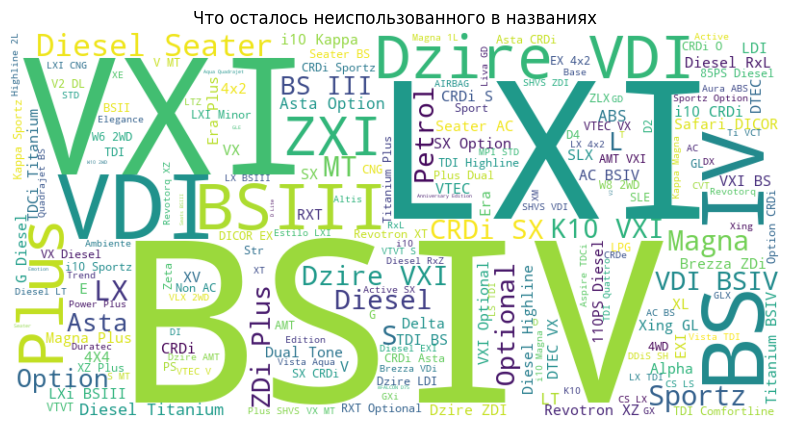

In [88]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(names_train_str)

plt.figure(figsize=(10, 5))
plt.title("Что осталось неиспользованного в названиях")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.show()

In [89]:
print('Количество униклаьных слов в оставшихся данных колонки name: ',
       len(np.unique(names_train_str.split())))

Количество униклаьных слов в оставшихся данных колонки name:  696


Можно использовать TF-IDS для преобразования этой колонки. Для этого
1. В `PreprocessorTFIDF` изменим, чтобы в колонке 'name' оставались неиспользованные данные
2. В `run_pipe_tfidf` добавим векторайзер

In [90]:
from importer import import_data
from pipeliner import run_pipe_tfidf

X_train, X_test, y_train, y_test = import_data()

run_pipe_tfidf(
    fill_method='median',
    X_train=X_train,
    y_train=y_train
)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 8 candidates, totalling 80 fits
fit run
transform run
Resulting shapes: (5840, 19)
**************************************************
{'model__alpha': 1}
Best R2 Score: 0.8076692649746977
**************************************************


Прибавка в 2%!

## Медиана VS ...

In [91]:
from importer import import_data
from pipeliner import run_pipe_tfidf

X_train, X_test, y_train, y_test = import_data()

run_pipe_tfidf(
    fill_method='mean',
    X_train=X_train,
    y_train=y_train
)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 8 candidates, totalling 80 fits
fit run
transform run
Resulting shapes: (5840, 19)
**************************************************
{'model__alpha': 1}
Best R2 Score: 0.8076771943283513
**************************************************


In [92]:
run_pipe_tfidf(
    fill_method='median',
    X_train=X_train,
    y_train=y_train
)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
fit run
transform run
Resulting shapes: (5840, 19)
**************************************************
{'model__alpha': 1}
Best R2 Score: 0.8076692649746977
**************************************************


Просто среднее ничего не дало, но и не ухудшило результат.

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [93]:
import numpy as np
from sklearn.metrics import make_scorer

def business_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    errors = np.abs((y_true - y_pred) / y_true)
    result = np.mean(errors > 0.1)

    return result

business_scorer = make_scorer(business_metrics, greater_is_better=False)

In [94]:
from importer import import_data
from pipeliner import run_pipe_business_ridge, run_pipe_business_lasso

X_train, X_test, y_train, y_test = import_data()

run_pipe_business_ridge(
    fill_method='mean',
    X_train=X_train,
    y_train=y_train
)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 9 candidates, totalling 90 fits
fit run
transform run
Resulting shapes: (5840, 19)
**************************************************
{'model__alpha': 0.1}
Best businness Score: 0.6241438356164384
**************************************************


Больше половины предсказаний отличается от истины более чем на 10%

In [95]:
run_pipe_business_lasso(
    fill_method='mean',
    X_train=X_train,
    y_train=y_train
)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
fit run
transform run
Resulting shapes: (5840, 19)
**************************************************
{'model__alpha': 1}
Best businness Score: 0.6215753424657533
**************************************************


c:\Users\user\MyGitRepos\masters\ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.097e+13, tolerance: 1.674e+11
  model = cd_fast.enet_coordinate_descent(


Lasso показывает результат немного хуже, чем Ridge

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



Я использовал взвешенную MSE, где недопрогноз штрафуется повышающим коэффициентом

In [96]:
import numpy as np

def weighted_mse(y_true, y_pred, coef = 2):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    errors = np.where(
        (y_pred - y_true) < 0,
        coef * (y_pred - y_true)**2,
        (y_pred - y_true)**2
    )
    result = np.mean(errors)

    return result

In [97]:
from importer import import_data
from pipeliner import run_pipe_ridge_weighted_mse, run_pipe_lasso_weighted_mse

X_train, X_test, y_train, y_test = import_data()

run_pipe_ridge_weighted_mse(
    fill_method='mean',
    X_train=X_train,
    y_train=y_train
)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 9 candidates, totalling 90 fits
fit run
transform run
Resulting shapes: (5840, 19)
**************************************************
{'model__alpha': 1}
Best weighted MSE: 101409970121.41548
Best weighted RMSE: 318449.3211194137
**************************************************


In [98]:
run_pipe_lasso_weighted_mse(
    fill_method='mean',
    X_train=X_train,
    y_train=y_train
)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
fit run
transform run
Resulting shapes: (5840, 19)
**************************************************
{'model__alpha': 10}
Best weighted MSE: 113695311302.79337
Best weighted RMSE: 337187.3534146756
**************************************************


c:\Users\user\MyGitRepos\masters\ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+13, tolerance: 1.674e+11
  model = cd_fast.enet_coordinate_descent(


Для этой задачи Lasso также показала результат похуже. Но сами значения метрик теперь сложно как-то интерпретировать

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

## Собираем последнюю версию модели

Проверяем предобработчик

In [99]:
from preprocessor import SuperPreprocessor
from importer import import_data
import pandas as pd

X_train, X_test, y_train, y_test = import_data()

super_preprocessor = SuperPreprocessor()
super_preprocessor.fit(X_train)

X_transformed = super_preprocessor.transform(X_train)
X_transformed.head(2)

Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)


,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,max_torque,min_torque_rpm,max_torque_rpm,hppl,nmpl,year_squared,brand,model
0,Dzire VDI,2014,145500,Diesel,Individual,Manual,First Owner,23.4,1248.0,74.0,5.0,190.0,2000.0,2000.0,59.294872,152.243590,4056196,Maruti,Swift
1,1.5 TDI Ambition,2014,120000,Diesel,Individual,Manual,Second Owner,21.1,1498.0,103.5,5.0,250.0,1500.0,2500.0,69.092123,166.889186,4056196,Skoda,Rapid


Обучаем модель

In [100]:
from preprocessor import SuperPreprocessor
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from pandas.errors import PerformanceWarning
import warnings
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.metrics import r2_score
from importer import import_data

warnings.simplefilter("ignore", PerformanceWarning)
random.seed(42)
np.random.seed(42)

X_train, X_test, y_train, y_test = import_data()
X_test = X_test.drop_duplicates()
y_test = y_test[X_test.index]

number_cols = ['year', 'km_driven', 'mileage', 'engine', 'max_power',
                'max_torque', 'min_torque_rpm', 'max_torque_rpm',
                'hppl', 'nmpl', 'year_squared']

cat_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'brand', 'model', 'seats']

text_cols = 'name'

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=1000))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, number_cols),
        ('cat', cat_transformer, cat_cols),
        ('text', text_transformer, 'name')
    ], remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('super_preprocessor', SuperPreprocessor(fill_method='mean')),
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

param_grid = {
    'model__alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000, 100000]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='r2',
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)
train_score = r2_score(y_train, y_pred_train)
test_score = r2_score(y_test, y_pred_test)

print('*'*50)
print(grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)
print('*'*50)
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")
print('*'*50)


Train data shape: (5840, 12) (5840,)
Test data shape:  (1000, 12) (1000,)
Fitting 10 folds for each of 8 candidates, totalling 80 fits
**************************************************
{'model__alpha': 1}
Best R2 Score: 0.8076771943283513
**************************************************
Train score: 0.9269568764715912
Test score: 0.9151893897891119
**************************************************


c:\Users\user\MyGitRepos\masters\ML\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Под конец я также удалил дубликаты из тестовой выборки, чтобы оценка финального скора была адекватной. Тестовый скор получился вполне неплохим: $r^2 = 0.915$

## Логируем модель

In [101]:
with open("data/trained_pipeline.pkl", "wb") as f:
    pickle.dump(grid_search, f)

In [102]:
df_train = pd.read_csv('data/df_train.csv', index_col='Unnamed: 0')
df_train[:3].to_json('data/many_examples.json', orient='records')
df_train.loc[0, :].to_json('data/one_example.json')

In [103]:
from preprocessor import SuperPreprocessor
import pickle
import pandas as pd
import numpy as np
import json

with open("data/trained_pipeline.pkl", "rb") as f:
    trained_pipeline = pickle.load(f)

with open('data/many_examples.json', mode='r') as file:
    df_many = json.load(file)

X = pd.DataFrame(df_many)
X = X.drop('selling_price', axis=1)
trained_pipeline.predict(X)

array([481196.95327052, 451251.58462171, 278968.95278435])

## Сервис на Fast API

In [104]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import pickle
import pandas as pd
from preprocessor import SuperPreprocessor
import numpy as np

with open("data/trained_pipeline.pkl", "rb") as f:
    trained_pipeline = pickle.load(f)

app = FastAPI()

class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


def get_one_x(item: Item):
    df = pd.DataFrame([item.model_dump()])
    X = df.drop('selling_price', axis=1)

    return X

def get_many_x(items: List[Item]):
    df = pd.DataFrame([item.model_dump() for item in items])
    X = df.drop('selling_price', axis=1)

    return X

@app.get("/")
def predict_item(test_key: str) -> str:
    return f"Hi there! It's a test endpoint. You passes a key: {test_key}"

@app.post("/predict_item")
def predict_item(item: Item) -> float:
    X = get_one_x(item)
    predictions = trained_pipeline.predict(X)

    return predictions


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    X = get_many_x(items)
    predictions = trained_pipeline.predict(X)
    
    return predictions

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>